# Workshop 5

Starter code for workshop 5. You should have seen most of it before, but make sure you understand what it is doing!

In [1]:
# Common imports
import sys
import sklearn
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To plot even prettier figures
import seaborn as sn

# General data handling (pure numerics are better in numpy)
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
# Get data
data = load_breast_cancer()

In [3]:
# Extract the features and target
xarray = data.data
yarray = data.target
fullarray = np.concatenate((xarray,np.reshape(yarray,(-1,1))),axis=1)

In [4]:
# Create a dataframe
fullarray[:,-1] = 1 - fullarray[:,-1]   # now invert the labels (so that malignant=1)
df = pd.DataFrame(fullarray,columns = list(data.feature_names) + ['target'])

The code below is incomplete and will require some editing to work ...

# Splitting into separate datasets

In [5]:
from sklearn.model_selection import train_test_split

# Split our dataset in train, val and test
bigtrain_set, test_set = train_test_split(fullarray, test_size=0.2, random_state=42, stratify=fullarray[:,-1])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, random_state=42, stratify=bigtrain_set[:,-1])

In [6]:
# Check dimmensions of our dataset
X_train = train_set[:,:-1]
y_train = train_set[:,-1]
X_test = test_set[:,:-1]
y_test = test_set[:,-1]
X_val = val_set[:,:-1]
y_val = val_set[:,-1]
print(f'Shapes are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes are [(341, 30), (341,), (114, 30), (114,), (114, 30), (114,)]


# Pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Creatae a general pipeline to transform our data
preproc_pl = Pipeline([ ('imputer', SimpleImputer(strategy="median")), 
                        ('std_scaler', StandardScaler()) ])

# SGD Classifier

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, hinge_loss
import random

# This function allows you to notice how SGD classifier works behind the scenes
def sgdfn(nsamp, learnrate):
    # We need to set a SGD classifier model. Important parameters:
        # warm_start = True allows you to reuse previous solution to fit the initial parameter values
        # eta0 = learnrate sets the learning rate
        # learning_rate = 'contant' sets the same learning rate thorught all the iterations
    sgd = SGDClassifier(warm_start=True, learning_rate='constant', eta0=learnrate) 
    # We preprocess our data
    X_trainp = preproc_pl.fit_transform(X_train)
    X_valp = preproc_pl.transform(X_val)
    # Create a list to save results
    res=[]

    # We go do 1000 iterations
    for n in range(2000):
        # Select the sample with the size "nsamp"
        sample = random.sample(range(0, X_train.shape[0]), nsamp)
        # Train SGD with a part of the data. partial_fit perfoms one epoch over data
        sgd.partial_fit(X_trainp[sample,:],y_train[sample],classes=[0,1])
        # Make prediction
        y_val_pred = sgd.predict(X_valp)
        # Get accuracy
        sgd_acc = accuracy_score(y_val,y_val_pred)
        # Get the loss. Hinge loss is the default loss function
        sgd_loss = hinge_loss(y_val,y_val_pred)
        # Save results
        res += [[sgd_acc,sgd_loss]]

    # Create the result
    res = np.array(res)

    # Create the plot with results
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(res[:,0])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(122)
    plt.plot(res[:,1])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.show()

    print("The final accuracy is: ", res[-1,0])
    print("The final loss is: ", res[-1,1])


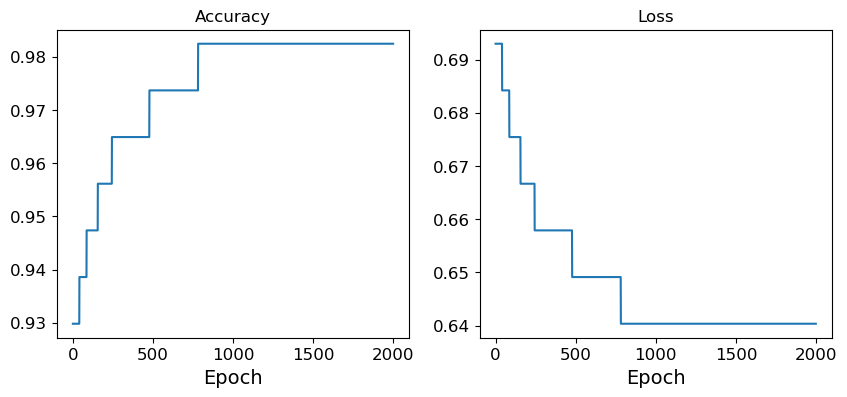

The final accuracy is:  0.9824561403508771
The final loss is:  0.6403508771929824


In [9]:
# We can try different sample size
ntrain = int(X_train.shape[0]*0.8)
# Implement our function
sgdfn(ntrain,0.00001)

# Evaluating the best setting in test data

In [10]:
# Create the final model 
sgd = SGDClassifier(learning_rate='constant', eta0=0.0001, 
                        early_stopping=False)   
sgd_pipe = Pipeline([('preproc',preproc_pl),('sgd',sgd)])

# Evaluate in validation
sgd_pipe.fit(X_train,y_train)
y_val_pred = sgd_pipe.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

# Evaluate in testing. Do you notice something interesting here? We are using train and val data to train
sgd_pipe.fit(np.concatenate((X_train,X_val),axis=0),np.concatenate((y_train,y_val),axis=0))
y_test_pred = sgd_pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f'Validation and Test accuracies are: {val_acc} and {test_acc}')

Validation and Test accuracies are: 0.9736842105263158 and 0.9736842105263158
